In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
from src.preprocessing.sequence_classification.set_fit_dataset import SetFitDataset
from src.model.sequence_classification.trainer import SequenceClassificationTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "PET"
dataset_name = "AG_news"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Loading dataset

In [4]:
tokenizer= AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
ag_news_dataset = load_dataset("ag_news")

In [6]:
ag_news_dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

In [7]:
classes_names = ag_news_dataset['train']\
    .features['label']\
    .names

classes_names[3] = "Science"

num_classes = len(classes_names)
num_classes

4

In [8]:
classes2idx = {
    label: idx for idx, label in enumerate(classes_names) 
}

idx2classes = {
    idx: label for idx, label in enumerate(classes_names) 
}

## Preprocessing

In [9]:
train_text, train_labels = get_n_shots_per_class(
    ag_news_dataset['train']['text'],
    ag_news_dataset['train']['label'],
    n_shots=2,
    num_classes=num_classes
)

In [10]:
val_text, val_labels = get_n_shots_per_class(
    ag_news_dataset['test']['text'],
    ag_news_dataset['test']['label'],
    n_shots=100,
    num_classes=num_classes
)

In [11]:
def pattern1(text: str, tokenizer : AutoTokenizer):
    return tokenizer.mask_token + " News: " + text  

In [12]:
def preprocess(text : List[str], labels : List[int]):

    processed_text = []
    processed_labels = []
    for idx in range(len(text)):
        label = idx2classes[labels[idx]]
        text_ = text[idx]

        processed_text.append(pattern1(text_, tokenizer))
        processed_labels.append(label)

    return processed_text, processed_labels

In [13]:
processed_text_train, labels_train = preprocess(
    train_text,
    train_labels
)

processed_text_val, labels_val = preprocess(
    val_text,
    val_labels
)

In [14]:
verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(classes_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(classes_names)}

In [15]:
processed_text_train

['[MASK] News: Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\\and in large numbers on Sunday to vote in a historic referendum\\that will either remove left-wing President Hugo Chavez from\\office or give him a new mandate to govern for the next two\\years.',
 '[MASK] News: S.Koreans Clash with Police on Iraq Troop Dispatch (Reuters) Reuters - South Korean police used water cannon in\\central Seoul Sunday to disperse at least 7,000 protesters\\urging the government to reverse a controversial decision to\\send more troops to Iraq.',
 "[MASK] News: Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final. Phelps' rivals Ian Thorpe and Pieter van den Hoogenband and teammate Klete Keller were faster than the teenager in the 200 free preliminaries.",
 

In [16]:
class PETDatasetForClassification(Dataset):
    def __init__(
        self, 
        processed_text : List[str], 
        labels : List[int],
        tokenizer : AutoTokenizer,
        device : str = "cuda"
    ) -> None:
        super().__init__()

        self.tokens = tokenizer(
            processed_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        self.encoded_labels = deepcopy(self.tokens['input_ids'])
        
        self.encoded_labels[self.encoded_labels != tokenizer.mask_token_id] = -100

        for idx, sentence in enumerate(self.encoded_labels):
            sentence[sentence == tokenizer.mask_token_id] = tokenizer.vocab[labels[idx].lower()]

        self.inputs : Dict[str, torch.Tensor] = self.tokens
        self.inputs['labels'] = self.encoded_labels

        for k,v in self.inputs.items():
            self.inputs[k] = v.to(device)

    def __getitem__(self, index):
        d : Dict = dict()
        for key in self.inputs.keys():
            d[key] = self.inputs[key][index]

        return d
    
    def __len__(self):
        return self.tokens['input_ids'].shape[0]

In [17]:
train_dataset = PETDatasetForClassification(
    processed_text_train,
    labels_train,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    processed_text_val,
    labels_val,
    tokenizer
)

In [18]:
train_dataloader = DataLoader(train_dataset)
val_dataloader =DataLoader(val_dataset)

## Importing models

In [19]:

def get_y_true(
    input: Dict[str, torch.Tensor],
    device : str = "cuda"
)-> torch.tensor:
    
    y_true = input['labels']
    y_true = y_true[y_true!= -100].item()
    y_true = inverse_verbalizer[y_true]
    
    return torch.tensor(y_true, device= device)

In [20]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased").to(device)

In [57]:
def train(
    train_dataloader : DataLoader,
    val_dataloader : DataLoader,
    model : AutoModelForMaskedLM,
    alpha : float,
    lr : float = 1e-5
):

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = lr
    )


    n_epochs = 10

    best_f1=  0
    confusion_matrix= None

    history = []

    for epoch in range(n_epochs):

        for input in train_dataloader:
            out = model(**input)

            loss_mlm = out['loss']

            y_true = get_y_true(input)

            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]
            mask_token_logits = out.logits[0, mask_token_index, :]
            
            predictions = torch.Tensor(
                [mask_token_logits[0,x] for x in verbalizer.values()]
            )

            probabilities = predictions.softmax(dim = 0).to(device)

            loss_ce = cross_entropy(
                probabilities,
                y_true
            )
            loss_ce.requires_grad = True

            loss = alpha*loss_mlm + (1-alpha)* loss_ce
            

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        with torch.no_grad():    
            y_true_val = torch.tensor([],device=device)
            y_pred_val = torch.tensor([],device=device)

            for input in tqdm(val_dataloader):
                out = model(**input)

                y_true = get_y_true(input)

                mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]
                mask_token_logits = out.logits[0, mask_token_index, :]
                
                predictions = torch.Tensor(
                    [mask_token_logits[0,x] for x in verbalizer.values()]
                )

                y_pred = predictions.argmax().to(device)

                y_pred_val = torch.cat([
                    y_pred_val, 
                    torch.tensor([y_pred]).to(device)
                ])

                y_true_val = torch.cat([
                    y_true_val,
                    torch.tensor([y_true]).to(device)
                ])
            
            f1 = multiclass_f1_score(
                y_pred_val,
                y_true_val,
                num_classes= num_classes
            )


            conf_matrix = multiclass_confusion_matrix(
                y_pred_val.to(torch.int64),
                y_true_val.to(torch.int64),
                num_classes= num_classes
            )

            if f1 > best_f1:
                best_f1 = f1
                confusion_matrix = conf_matrix

            history.append(f1.item())

            logging.info("-------------------------")
            logging.info(f"End of epoch {epoch}: f1 = {f1.item()}")
            logging.info(conf_matrix)
    
    return history, confusion_matrix

In [58]:
total_history = {}

## Two shots

In [59]:
n_shots = 2

In [60]:
train_text, train_labels = get_n_shots_per_class(
    ag_news_dataset['train']['text'],
    ag_news_dataset['train']['label'],
    n_shots=n_shots,
    num_classes=num_classes
)
val_text, val_labels = get_n_shots_per_class(
    ag_news_dataset['test']['text'],
    ag_news_dataset['test']['label'],
    n_shots=100,
    num_classes=num_classes
)

In [61]:
processed_text_train, labels_train = preprocess(
    train_text,
    train_labels
)

processed_text_val, labels_val = preprocess(
    val_text,
    val_labels
)

In [62]:
train_dataset = PETDatasetForClassification(
    processed_text_train,
    labels_train,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    processed_text_val,
    labels_val,
    tokenizer
)

In [63]:
train_dataloader = DataLoader(train_dataset)
val_dataloader =DataLoader(val_dataset)

In [64]:
history, confusion_matrix = train(
    train_dataloader,
    val_dataloader,
    model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased").to(device),
    alpha = 1e-5
)

total_history[f'{n_shots} shots'] = history

100%|██████████| 400/400 [00:04<00:00, 90.40it/s]


In [65]:
best_epoch = np.argmax(history)
best_f1 = np.max(history)

Text(0.5, 1.0, 'PET training results- AG news - 2 shots')

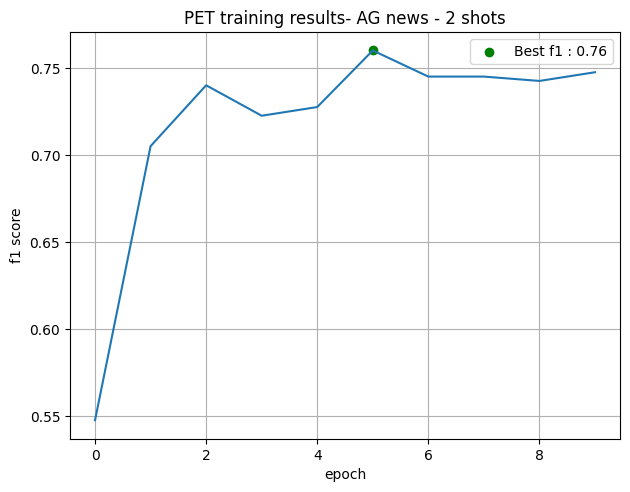

In [66]:
plt.plot(history)
plt.scatter(
    [best_epoch], 
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title(f"PET training results- AG news - {n_shots} shots")

Text(0.5, 1.0, '\n    Confusion matrix\n    PET - 2 shots AgNews\n')

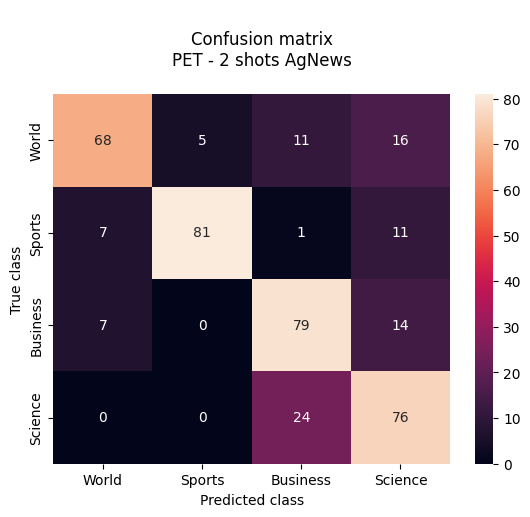

In [68]:
confusion_df = pd.DataFrame(confusion_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in classes2idx.items()})\
    .rename(index = {v:k for k, v in classes2idx.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix
    PET - {n_shots} shots AgNews
''')

## 5 shots

In [69]:
n_shots = 5

In [70]:
train_text, train_labels = get_n_shots_per_class(
    ag_news_dataset['train']['text'],
    ag_news_dataset['train']['label'],
    n_shots=n_shots,
    num_classes=num_classes
)
val_text, val_labels = get_n_shots_per_class(
    ag_news_dataset['test']['text'],
    ag_news_dataset['test']['label'],
    n_shots=100,
    num_classes=num_classes
)

In [71]:
processed_text_train, labels_train = preprocess(
    train_text,
    train_labels
)

processed_text_val, labels_val = preprocess(
    val_text,
    val_labels
)

In [72]:
train_dataset = PETDatasetForClassification(
    processed_text_train,
    labels_train,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    processed_text_val,
    labels_val,
    tokenizer
)

In [73]:
train_dataloader = DataLoader(train_dataset)
val_dataloader =DataLoader(val_dataset)

In [83]:
history, confusion_matrix = train(
    train_dataloader,
    val_dataloader,
    model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased").to(device),
    alpha = 1e-5
)

total_history[f'{n_shots} shots'] = history

100%|██████████| 400/400 [00:04<00:00, 90.44it/s]


In [79]:
best_epoch = np.argmax(history)
best_f1 = np.max(history)

Text(0.5, 1.0, 'PET training results- AG news - 5 shots')

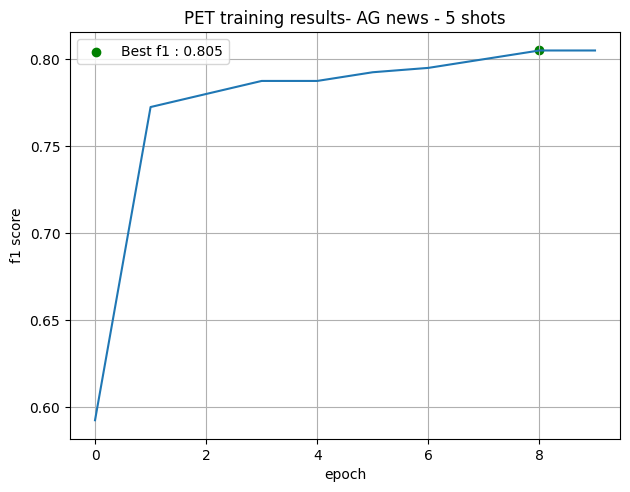

In [80]:
plt.plot(history)
plt.scatter(
    [best_epoch], 
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title(f"PET training results- AG news - {n_shots} shots")

Text(0.5, 1.0, '\n    Confusion matrix\n    PET - 5 shots AgNews\n')

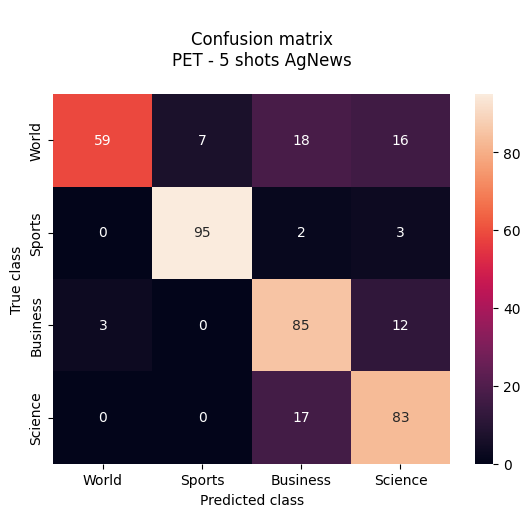

In [81]:
confusion_df = pd.DataFrame(confusion_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in classes2idx.items()})\
    .rename(index = {v:k for k, v in classes2idx.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix
    PET - {n_shots} shots AgNews
''')

## 10 shots

In [84]:
n_shots = 10

In [85]:
train_text, train_labels = get_n_shots_per_class(
    ag_news_dataset['train']['text'],
    ag_news_dataset['train']['label'],
    n_shots=n_shots,
    num_classes=num_classes
)
val_text, val_labels = get_n_shots_per_class(
    ag_news_dataset['test']['text'],
    ag_news_dataset['test']['label'],
    n_shots=100,
    num_classes=num_classes
)

In [86]:
processed_text_train, labels_train = preprocess(
    train_text,
    train_labels
)

processed_text_val, labels_val = preprocess(
    val_text,
    val_labels
)

In [87]:
train_dataset = PETDatasetForClassification(
    processed_text_train,
    labels_train,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    processed_text_val,
    labels_val,
    tokenizer
)

In [88]:
train_dataloader = DataLoader(train_dataset)
val_dataloader =DataLoader(val_dataset)

In [89]:
history, confusion_matrix = train(
    train_dataloader,
    val_dataloader,
    model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased").to(device),
    alpha = 1e-5
)

total_history[f'{n_shots} shots'] = history

100%|██████████| 400/400 [00:04<00:00, 88.91it/s]


In [90]:
best_epoch = np.argmax(history)
best_f1 = np.max(history)

Text(0.5, 1.0, 'PET training results- AG news - 10 shots')

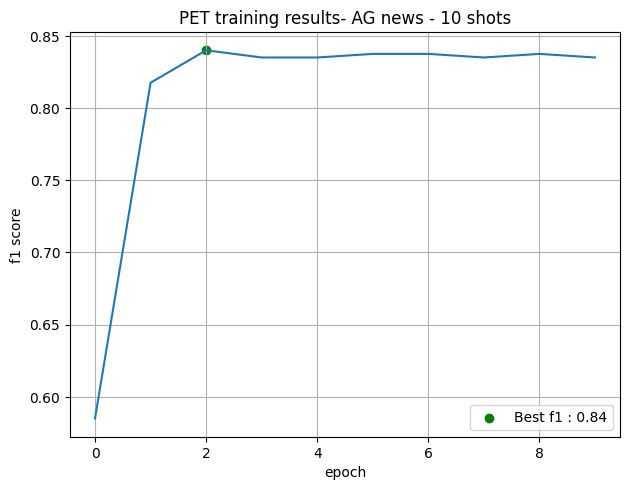

In [91]:
plt.plot(history)
plt.scatter(
    [best_epoch], 
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title(f"PET training results- AG news - {n_shots} shots")

Text(0.5, 1.0, '\n    Confusion matrix\n    PET - 10 shots AgNews\n')

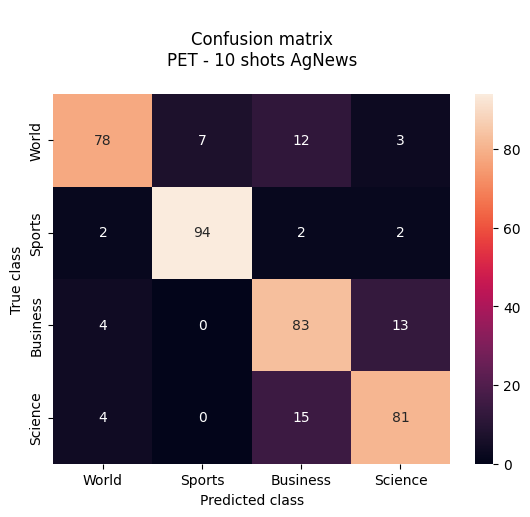

In [92]:
confusion_df = pd.DataFrame(confusion_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in classes2idx.items()})\
    .rename(index = {v:k for k, v in classes2idx.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix
    PET - {n_shots} shots AgNews
''')

## History

Text(0.5, 1.0, 'PET training results- AG news')

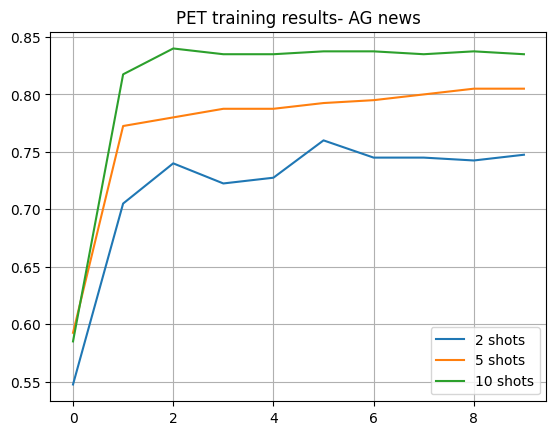

In [98]:
for k, v in total_history.items():
    plt.plot(
        v,
        label = k
    )

plt.grid()
plt.legend()
plt.title("PET training results- AG news")